## generate previous frames with pCO2 and fit it against ConvLSTM for multiple members

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras
import os

sys.path.insert(0, '../../src')

from utils import df_to_xarray,read_xarray, custom_rmse

sys.path.insert(0, '../../src/preprocess')
from data_preprocess import preprocess_image_reduced,preprocess_images_nfp, inverse_scale_frame
from data_preprocess import preprocess_images, inverse_scale_image, preprocess_image_reduced

/burg/glab/users/sk4973/venv2/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2023-01-02 22:52:40.647667: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot


print('statsmodels: %s' % statsmodels.__version__)

statsmodels: 0.13.5


In [3]:
dist_map = pd.read_csv("../../src/dist_map.csv",header=None).to_numpy()
dist_map = np.roll(np.fliplr(dist_map),180)
dist_map = np.repeat(dist_map[np.newaxis, :, : ], 421, axis=0)

def custom_rmse2(y_true, y_pred):
    """
    custom_rmse(y_true, y_pred)
    calculates root square mean value with focusing only on the ocean
    + difference between sss
    """
    idx  = tf.not_equal(y_true, 0.0)
    idx2  = tf.equal(y_true, 0.0)
    
    y_pred1 = tf.boolean_mask(y_pred,idx)
    y_true1 = tf.boolean_mask(y_true,idx)
    y_true1 = tf.cast(y_true1, y_pred.dtype)
    
    rmse1 = K.sqrt(K.mean(tf.math.squared_difference(y_pred1, y_true1),axis= -1))
    
    #y_pred2 = tf.boolean_mask(y_pred,idx2)
    #loss2 = 10*(K.var(y_true1)/K.var(y_pred2))
    #loss2 = tf.cast(loss2, y_pred.dtype)
    
    return rmse1

In [4]:
mpi_data_path = "../../data/mpi_001"


def read_xarray_mpi(dir_name="",num="006"):
    '''
     read_xarray(dir)name) opens data and returns data in xarray format for each feature mpi
    '''
    date="198201-201701"
  
    file_type ="MPI"
        
    chl = xr.open_dataset(f'{dir_name}/Chl_2D_mon_{file_type}{num}_1x1_{date}.nc')

    mld = xr.open_dataset(f'{dir_name}/MLD_2D_mon_{file_type}{num}_1x1_{date}.nc')

    sss = xr.open_dataset(f'{dir_name}/SSS_2D_mon_{file_type}{num}_1x1_{date}.nc')

    sst = xr.open_dataset(f'{dir_name}/SST_2D_mon_{file_type}{num}_1x1_{date}.nc')

    xco2 = xr.open_dataset(f'../../data/member_001/XCO2_1D_mon_CESM001_native_198201-201701.nc')

    pco2 = xr.open_dataset(f'{dir_name}/pCO2_2D_mon_{file_type}{num}_1x1_{date}.nc')

    return chl,mld,sss,sst,xco2,pco2


chl,mld,sss,sst,xco2,pco2 = read_xarray_mpi(mpi_data_path)

# def pco2_socat_preprocess(arr):
#     tmp_arr=arr[arr!=0.0]
#     coord = ((arr==0))
#     min_pixel, max_pixel = np.nanmin(tmp_arr), np.nanmax(tmp_arr)
    
#     output = (arr-min_pixel)*(255)/(max_pixel-min_pixel)
#     output[coord]=0
#     return output, min_pixel, max_pixel

# def inverse_pco2_socat(arr,min_pixel,max_pixel=1000):
#     y_pred = arr*(max_pixel-min_pixel)/255+min_pixel
#     return y_pred

def pco2_socat_preprocess(arr):
    nans=np.isnan(arr)
    min_val=arr[~nans].min()
    arr[nans]=min_val
    return arr

/burg/glab/users/sk4973/venv2/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
ecCodes library not found using ['eccodes', 'libeccodes.so', 'libeccodes']
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


## transfer learning on canESM


In [5]:
chl_images = preprocess_image_reduced(chl.Chl.data)
sss_images = preprocess_image_reduced(sss.SSS.data)
sst_images = preprocess_image_reduced(sst.SST.data)
mld_images = preprocess_image_reduced(mld.MLD.data)
xco2_images = preprocess_image_reduced(xco2.XCO2.data,xco2=True)
pco2_socat_images= pco2_socat_preprocess(pco2.pCO2_socat.data)

dist_map = preprocess_image_reduced(dist_map)

X_tf = np.dstack((chl_images, dist_map, sss_images, sst_images, xco2_images))
y_tf = pco2_socat_images
X_tf = X_tf.reshape((421,180,360,5),order='F')
frame = 1
X_index=np.lib.stride_tricks.sliding_window_view(range(421),frame)
X2_tf = X_tf[X_index][:-1]
y2_tf=pco2_socat_images[X_index][1:]
X_tf,y_tf=X_tf[:421-frame],y_tf[:421-frame]


In [6]:
X_tf.shape, y_tf.shape, X2_tf.shape, y2_tf.shape

((420, 180, 360, 5),
 (420, 180, 360),
 (420, 1, 180, 360, 5),
 (420, 1, 180, 360))

In [7]:
np.min(pco2_socat_images), np.max(pco2_socat_images), np.std(pco2_socat_images)

(0.0, 710.2517700195312, 34.770610971137785)

In [8]:
tf.keras.backend.clear_session()

# transfer learning
model_path="../../models/pretrain_final.h5"
model = tf.keras.models.load_model(model_path, custom_objects={'custom_rmse':custom_rmse})


ls=[12,13,14,15,16,17,18,19,24,25,26,27,28,29,30]

ind=0

for layer in model.layers:
    if ind not in ls:
        layer.trainable = False
    else:
        layer.trainable = True
        print(str(ind),":",layer)
    ind+=1

model.summary()

2023-01-02 22:53:51.404804: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-02 22:53:51.406479: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-01-02 22:53:51.447229: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:d8:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 72 deviceMemorySize: 44.49GiB deviceMemoryBandwidth: 581.23GiB/s
2023-01-02 22:53:51.447270: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-01-02 22:53:52.151114: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-01-02 22:53:52.151197: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2023-0

12 : <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1554c1dce1c0>
13 : <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x15551ac9c430>
14 : <tensorflow.python.keras.layers.core.Dropout object at 0x15551ac9c100>
15 : <tensorflow.python.keras.layers.convolutional.UpSampling2D object at 0x15551acb35e0>
16 : <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x15551acb3a30>
17 : <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x15551acb39d0>
18 : <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1553d5a2f250>
19 : <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x1553d5a2fac0>
24 : <tensorflow.python.keras.layers.convolutional_recurrent.ConvLSTM2D object at 0x1553d5a31c70>
25 : <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x1553d59e5880>
26 : <tensorflow.python.keras.layers.convolutional_recurrent.ConvLSTM2D object at 0x1553d59e5a60>
27 : <tensorflow.python.keras.lay

In [ ]:
from tensorflow.keras import backend as K

myLearnRate=0.002

model.compile(
    loss=[custom_rmse,custom_rmse], optimizer=keras.optimizers.Adam(learning_rate=myLearnRate),
)

model_path="../../models/transfer_CONVLSTM_mpi2.h5"

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

history = model.fit([X_tf,X2_tf],[y_tf,y2_tf], epochs=30, 
                         workers=-1,batch_size=16,
                         callbacks=callbacks)

In [9]:
cnn_model = tf.keras.models.load_model("../../models/transfer_CONVLSTM_mpi2.h5", custom_objects={'custom_rmse':custom_rmse})

predicted_image,predicted_frames = cnn_model.predict([X_tf,X2_tf],verbose=1)

2023-01-02 22:54:00.864004: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-01-02 22:54:00.885960: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2900000000 Hz
2023-01-02 22:54:01.667619: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2023-01-02 22:54:16.629539: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-01-02 22:54:20.465891: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


14/14 [==============================] - 27s 443ms/step


In [10]:
chl,mld,sss,sst,xco2,pco2 = read_xarray_mpi(mpi_data_path)

full_truth=np.nan_to_num(pco2.pCO2.data[:420])
coord = (full_truth==0)
predicted_image[coord]=0

tmp =np.nan_to_num(pco2.pCO2.data[X_index][1:])
y_true_full = np.expand_dims(tmp,axis=4)

coord2 = (y_true_full==0.0)
predicted_frames[coord2] = 0

In [36]:
#inv_predicted_image=inverse_pco2_socat(predicted_image,min_pixel,max_pixel)
#custom_rmse(inv_predicted_image,full_truth)


In [11]:
custom_rmse(predicted_image,full_truth)

<tf.Tensor: shape=(), dtype=float32, numpy=50.475677>

In [12]:
custom_rmse(predicted_frames,y_true_full)

<tf.Tensor: shape=(), dtype=float32, numpy=38.24788>

### Graph

/tmp/ipykernel_3567881/1820649490.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels(np.arange(280,440,20))
/tmp/ipykernel_3567881/1820649490.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar2.set_ticklabels(np.arange(280,440,20))


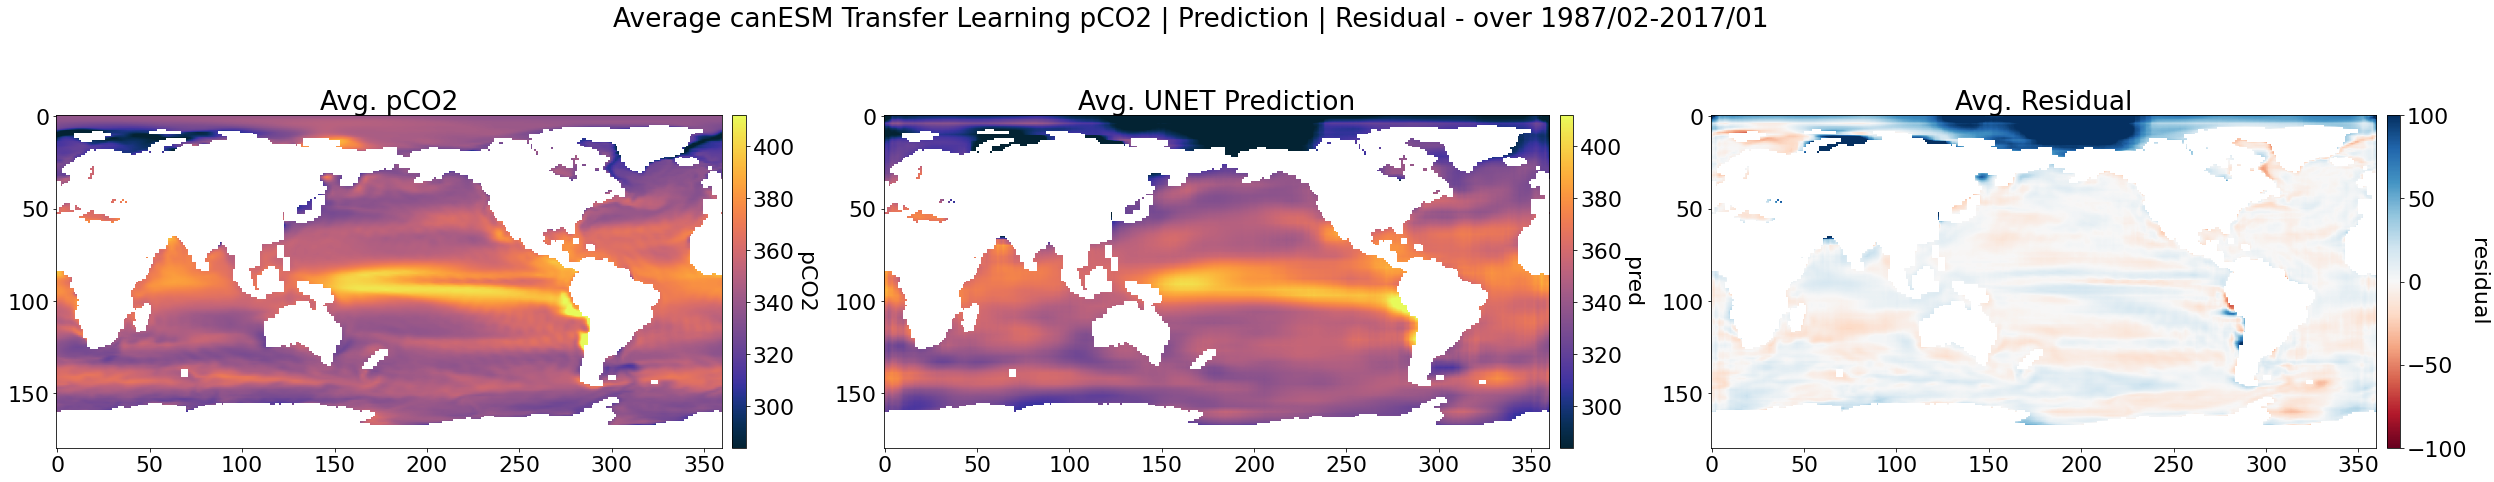

In [41]:
# CNN average Image
full_truth[coord] = np.nan
predicted_image[coord] = np.nan

res_unet = full_truth - predicted_image

avg_y_true = np.mean(full_truth,axis=0)
avg_y_pred = np.mean(predicted_image,axis=0)
avg_res = np.mean(res_unet,axis=0)

import cmocean as cm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

figure, axis = plt.subplots(1, 3,figsize=(42, 8))

plt.rcParams.update({'font.size': 22})
norm = mcolors.Normalize(vmin=280, vmax = 440)
norm2 = mcolors.TwoSlopeNorm(vmin=-100, vmax = 100, vcenter=0)

im0 = axis[0].imshow(np.flipud(avg_y_true),cmap = cm.cm.thermal,norm=norm,label="pCO2")
axis[0].set_title("Avg. pCO2")

divider = make_axes_locatable(axis[0])
cax = divider.append_axes('right', size='2%', pad=0.15)
cbar=figure.colorbar(im0, cax=cax, orientation='vertical')
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('pCO2', rotation=270)
cbar.set_ticklabels(np.arange(280,440,20))


im1 =axis[1].imshow(np.flipud(avg_y_pred),cmap = cm.cm.thermal,norm=norm,label="pCO2 pred")
axis[1].set_title("Avg. UNET Prediction")

divider = make_axes_locatable(axis[1])
cax = divider.append_axes('right', size='2%', pad=0.15)
cbar2=figure.colorbar(im1, cax=cax, orientation='vertical')
cbar2.ax.get_yaxis().labelpad = 20
cbar2.ax.set_ylabel('pred', rotation=270)
cbar2.set_ticklabels(np.arange(280,440,20))


im2=axis[2].imshow(np.flipud(avg_res),cmap = "RdBu",norm=norm2,label="residual")
axis[2].set_title("Avg. Residual")

divider = make_axes_locatable(axis[2])
cax = divider.append_axes('right', size='2%', pad=0.15)
cbar3=figure.colorbar(im2, cax=cax, orientation='vertical')
cbar3.ax.get_yaxis().labelpad = 20
cbar3.ax.set_ylabel('residual', rotation=270)
#cbar3.set_ticklabels(np.arange(-100,100,25))


figure.suptitle("Average canESM Transfer Learning pCO2 | Prediction | Residual - over 1987/02-2017/01")

plt.savefig("../../assets/figure6.0_unet_mpi2.jpg")

### ConvLSTM

/tmp/ipykernel_1540947/4025588919.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels(np.arange(280,440,20))
/tmp/ipykernel_1540947/4025588919.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar2.set_ticklabels(np.arange(280,440,20))


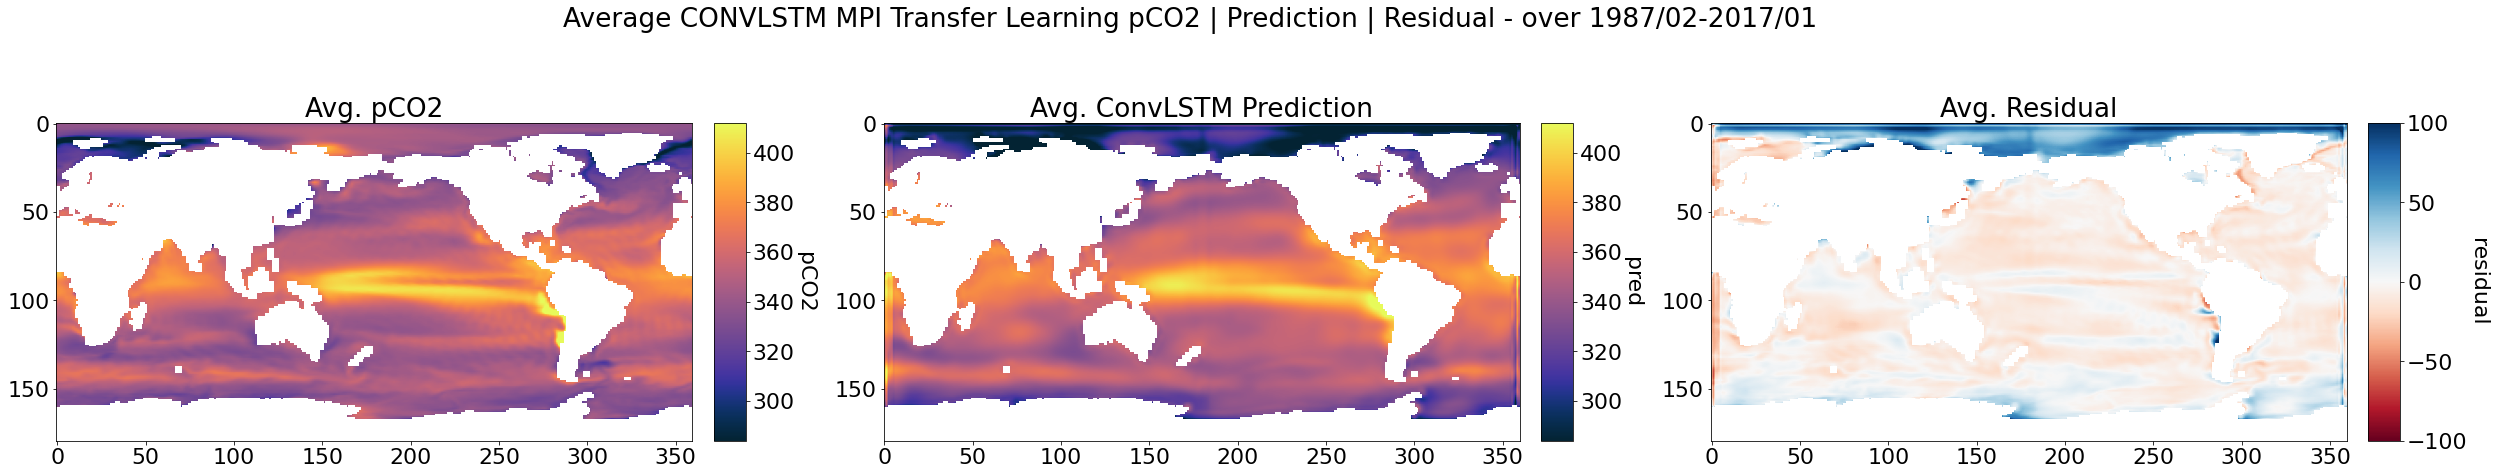

In [15]:
# ConvLSTM average Image
import cmocean as cm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
predicted_frames[coord2] = np.nan
y_true_full[coord2] = np.nan
avg_y_pred = np.mean(predicted_frames[:],axis=0)
avg_y_true = np.mean(y_true_full[:],axis=0)

res = y_true_full[:]-predicted_frames[:]
avg_res = np.mean(res,axis=0)
figure, axis = plt.subplots(1, 3,figsize=(42, 8))

plt.rcParams.update({'font.size': 22})
norm = mcolors.Normalize(vmin=280, vmax = 440)
norm2 = mcolors.TwoSlopeNorm(vmin=-100, vmax = 100, vcenter=0)

im0 = axis[0].imshow(np.flipud(avg_y_true[0]),cmap = cm.cm.thermal,norm=norm,label="pCO2")
axis[0].set_title("Avg. pCO2")

divider = make_axes_locatable(axis[0])
cax = divider.append_axes('right', size='5%', pad=0.3)
cbar=figure.colorbar(im0, cax=cax, orientation='vertical')
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('pCO2', rotation=270)
cbar.set_ticklabels(np.arange(280,440,20))

im1 =axis[1].imshow(np.flipud(avg_y_pred[0]),cmap = cm.cm.thermal,norm=norm,label="pCO2 pred")
axis[1].set_title("Avg. ConvLSTM Prediction")

divider = make_axes_locatable(axis[1])
cax = divider.append_axes('right', size='5%', pad=0.3)
cbar2=figure.colorbar(im1, cax=cax, orientation='vertical')
cbar2.ax.get_yaxis().labelpad = 20
cbar2.ax.set_ylabel('pred', rotation=270)
cbar2.set_ticklabels(np.arange(280,440,20))

im2=axis[2].imshow(np.flipud(avg_res[0]),cmap = "RdBu",norm=norm2,label="residual")
axis[2].set_title("Avg. Residual")

divider = make_axes_locatable(axis[2])
cax = divider.append_axes('right', size='5%', pad=0.3)
cbar3=figure.colorbar(im2, cax=cax, orientation='vertical')
cbar3.ax.get_yaxis().labelpad = 20
cbar3.ax.set_ylabel('residual', rotation=270)
#cbar3.set_ticklabels(np.arange(-100,100,20))
               
figure.suptitle("Average CONVLSTM MPI Transfer Learning pCO2 | Prediction | Residual - over 1987/02-2017/01")

plt.savefig("../../assets/figure6.0_convlstm_MPI.jpg")

(420, 1, 180, 360, 1)
(420, 1)


/burg/glab/users/sk4973/venv2/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


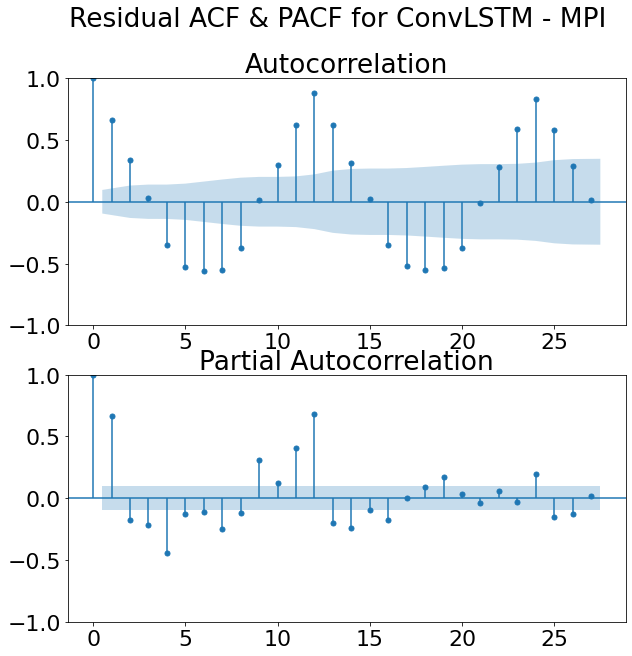

In [14]:
y_true_full[coord2]=np.nan
predicted_frames[coord2]=np.nan

res = y_true_full[:]-predicted_frames[:]

print(res.shape)

avg_time_res_convlstm=np.nanmean(res, axis=(1,2,3))
print(avg_time_res_convlstm.shape)

fig = pyplot.figure(figsize = (10,10))
pyplot.subplot(211)
plot_acf(avg_time_res_convlstm, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(avg_time_res_convlstm, ax=pyplot.gca())

fig.suptitle("Residual ACF & PACF for ConvLSTM - MPI")
plt.savefig("../../assets/figure7_convLSTM_mpi_acf.jpg")
pyplot.show()

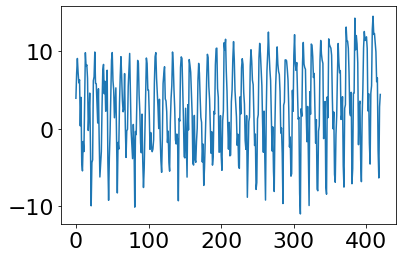

In [44]:
plt.plot(avg_time_res_convlstm)